# ***T20-CRICKET TEAM PERFORMANCE ANALYSIS PROJECT***

---



In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

***Data Loading***

In [59]:
all_datasets = []
all_datasets.append(pd.read_csv("RCB_IPL2024_FirstMatch.csv"))
all_datasets.append(pd.read_csv("RCB_IPL2024_Match2_vs_PBKS.csv"))
all_datasets.append(pd.read_csv("RCB_IPL2024_Match3_vs_GT.csv"))

df = pd.concat(all_datasets, ignore_index = True)

format_overs = 20
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Match_No            33 non-null     int64  
 1   Player_Name         33 non-null     object 
 2   Role                33 non-null     object 
 3   Batting_Position    33 non-null     int64  
 4   Batting_Start_Over  18 non-null     float64
 5   Out_Over            18 non-null     object 
 6   Balls_Played        18 non-null     float64
 7   Runs_Scored         18 non-null     float64
 8   Overs_Bowled        33 non-null     float64
 9   Runs_Given          16 non-null     float64
 10  Wickets_Taken       16 non-null     float64
dtypes: float64(6), int64(2), object(3)
memory usage: 3.0+ KB
None


***Data Validation***

In [60]:
def data_validation(df):
  bat_stats = (df["Batting_Start_Over"].isnull() &(df["Out_Over"].notnull() | df["Balls_Played"].notnull() | df["Runs_Scored"].notnull()))

  bat_stats2 = (df["Batting_Start_Over"].notnull() & (df["Out_Over"].isnull()))

  bowl_stats = ((df["Overs_Bowled"].isnull() | df["Overs_Bowled"] == 0) & (df["Runs_Given"].notnull() | df["Wickets_Taken"].notnull()))

  invalid_player = ((df["Player_Name"].isnull()) & ( df["Role"].notnull()| df["Batting_Position"].notnull() | df["Batting_Start_Over"].notnull() | df["Out_Over"].notnull() | df["Balls_Played"].notnull() | df["Runs_Scored"].notnull() | df["Overs_Bowled"].notnull() | df["Runs_Given"].notnull() | df["Wickets_Taken"].notnull()))

  no_match = df["Match_No"].isnull()

  if no_match.any():
    invalid_rows = df[no_match]
    print(invalid_rows)
    raise ValueError("Some players don't have Match Number information, can't proceed")

  elif invalid_player.any():
    invalid_rows = df[invalid_player]
    print(invalid_rows)
    raise ValueError("Some players don't have their name, can't proceed")

  elif (bat_stats.any()) or (bat_stats2.any()):
    invalid_rows = df[bat_stats]
    print(invalid_rows)
    raise ValueError("Invalid data found in batting columns, can't procced")

  elif bowl_stats.any():
    invalid_rows = df[bowl_stats]
    print(invalid_rows)
    raise ValueError("Invalid data found in bowling columns, can't procced")

  print("Dataset passed validation process, we can proceed further")


In [61]:
try:
  data_validation(df)
except Exception as err :
  print(f"Oops! We got some error as {err}")

Dataset passed validation process, we can proceed further


***Data Cleaning***

In [62]:
df2 = df.copy()

1. Handling null values

In [63]:
try :
  df2 = df2.dropna(subset = ["Player_Name"])
  df2["Batting_Position"] = df2["Batting_Position"].fillna("not-fixed")
  df2["Role"] = df2["Role"].fillna(df2["Role"].mode()[0])
  df2["Batting_Start_Over"] = df2["Batting_Start_Over"].fillna(0)
  df2["Out_Over"] = df2["Out_Over"].fillna(0)
  df2["Balls_Played"] = df2["Balls_Played"].fillna(0)
  df2["Runs_Scored"] = df2["Runs_Scored"].fillna(0)
  df2["Overs_Bowled"] = df2["Overs_Bowled"].fillna(0)
  df2.loc[(df2["Overs_Bowled"]>0.0) & (df2["Runs_Given"].isnull()), "Runs_Given"] = 0
  df2.loc[(df2["Overs_Bowled"]>0.0) & (df2["Wickets_Taken"].isnull()), "Wickets_Taken"] = 0
  df2["Runs_Given"] = df2["Runs_Given"].fillna(0)
  df2["Wickets_Taken"] = df2["Wickets_Taken"].fillna(0)
  df2.info()
except Exception as err :
  print(f"Oops! we got an as exception as {err}")
  print("\n")
  print("Please use Valid Datatypes")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Match_No            33 non-null     int64  
 1   Player_Name         33 non-null     object 
 2   Role                33 non-null     object 
 3   Batting_Position    33 non-null     int64  
 4   Batting_Start_Over  33 non-null     float64
 5   Out_Over            33 non-null     object 
 6   Balls_Played        33 non-null     float64
 7   Runs_Scored         33 non-null     float64
 8   Overs_Bowled        33 non-null     float64
 9   Runs_Given          33 non-null     float64
 10  Wickets_Taken       33 non-null     float64
dtypes: float64(6), int64(2), object(3)
memory usage: 3.0+ KB


2. Creating boolean Was_Out column for info of out/ not-out

In [64]:
df2["Was_Out"] = (df2["Batting_Start_Over"] > 0 & (df2["Out_Over"] != "not-out"))

***Feature Engineering***

Strike rate calculation

In [65]:
df2["Strike_Rate"] = ((df2["Runs_Scored"]/df2["Balls_Played"])*100).round(2)

Economy Rate calculation

In [66]:
def economy_calc(df2):
  over = df2["Overs_Bowled"].astype(int)
  balls = (df2["Overs_Bowled"] - over)* 10

  df2["real_over"] = over + (balls/6)
  df2["Economy_Rate"] = 0.0

  df2.loc[df2["real_over"] > 0, "Economy_Rate"] = df2.loc[df2["real_over"] > 0, "Runs_Given"]/df2.loc[df2["real_over"] > 0, "real_over"]
  df2.drop(columns=["real_over"], inplace = True)

  df2["Economy_Rate"] = df2["Economy_Rate"].round(2)

  return df2

df2 = economy_calc(df2)


In [67]:
df2.head()

,Match_No,Player_Name,Role,Batting_Position,Batting_Start_Over,Out_Over,Balls_Played,Runs_Scored,Overs_Bowled,Runs_Given,Wickets_Taken,Was_Out,Strike_Rate,Economy_Rate
0,1,Virat Kohli,batsman,1,0.1,18.5,59.0,77.0,0.0,0.0,0.0,True,130.51,0.00
1,1,Faf du Plessis,batsman,2,0.1,1.2,7.0,3.0,0.0,0.0,0.0,True,42.86,0.00
2,1,Cameron Green,all-rounder,3,1.2,1.3,5.0,3.0,2.0,19.0,0.0,True,60.00,9.50
3,1,Rajat Patidar,batsman,4,1.3,3.4,18.0,18.0,0.0,0.0,0.0,True,100.00,0.00
4,1,Glenn Maxwell,all-rounder,5,3.4,4.3,5.0,3.0,3.0,29.0,2.0,True,60.00,9.67


***EDA***

Difference Between Individual Runs Scored

---



In [68]:
done_batting = df2[df2["Balls_Played"]> 0]
runs_difference  = done_batting.groupby("Player_Name").agg({"Runs_Scored": "sum", "Balls_Played": "sum"}).sort_values(by = "Runs_Scored", ascending = False).astype(int)
runs_difference

,Runs_Scored,Balls_Played
Player_Name,,
Virat Kohli,239,150
Will Jacks,112,48
Rajat Patidar,73,41
Cameron Green,49,32
Dinesh Karthik,43,24
Mahipal Lomror,32,19
Faf du Plessis,12,14
Anuj Rawat,11,4
Saurav Chauhan,9,6


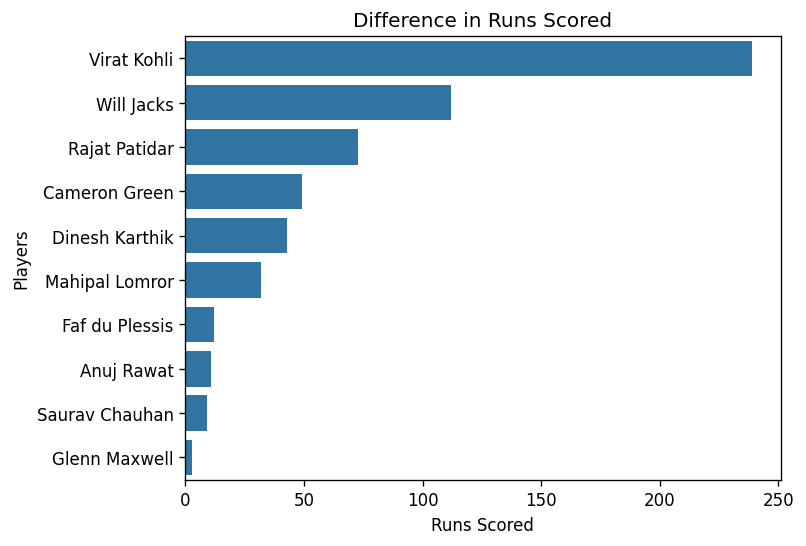

In [69]:
plt.figure(dpi = 120)
sns.barplot(y = runs_difference.index, x = runs_difference["Runs_Scored"])
plt.title("Difference in Runs Scored")
plt.ylabel("Players")
plt.xlabel("Runs Scored")
plt.show()

Total Runs Contribution

---



In [70]:
top_batters = ((done_batting.groupby("Player_Name")["Runs_Scored"].sum()).sort_values(ascending = False)).head()
others = runs_difference["Runs_Scored"].sum() - top_batters.sum()
batting_data = top_batters.copy()
batting_data["Others"] = others
batting_data = (batting_data[batting_data > 0])

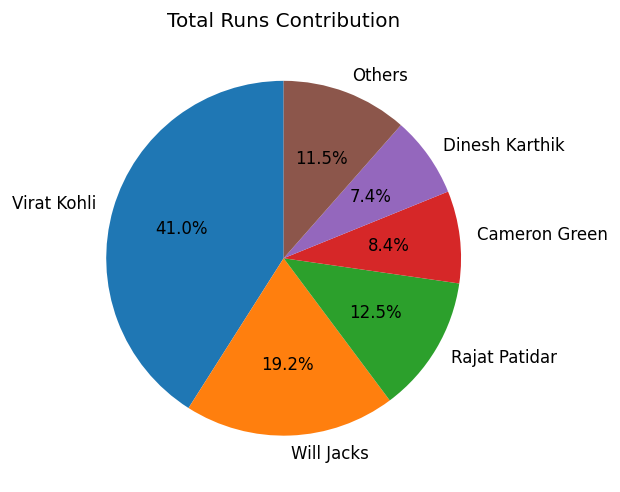

In [71]:
plt.figure(dpi = 120)
plt.pie(batting_data, labels=batting_data.index, autopct="%1.1f%%", startangle=90)
plt.title("Total Runs Contribution")
plt.show()

Difference Between Individual Wickets Taken

---



In [72]:
done_bowling = df2[df2["Overs_Bowled"]> 0]
bowling_diff = (done_bowling.groupby("Player_Name").agg({"Wickets_Taken": "sum", "Overs_Bowled" : "sum"})).sort_values(by = "Wickets_Taken",ascending = False)
bowling_diff

,Wickets_Taken,Overs_Bowled
Player_Name,,
Yash Dayal,6.0,12.0
Swapnil Singh,4.0,8.0
Cameron Green,3.0,9.0
Glenn Maxwell,2.0,3.0
Karn Sharma,1.0,8.0
Lockie Ferguson,0.0,1.0
Mohammed Siraj,0.0,12.0
Will Jacks,0.0,2.0


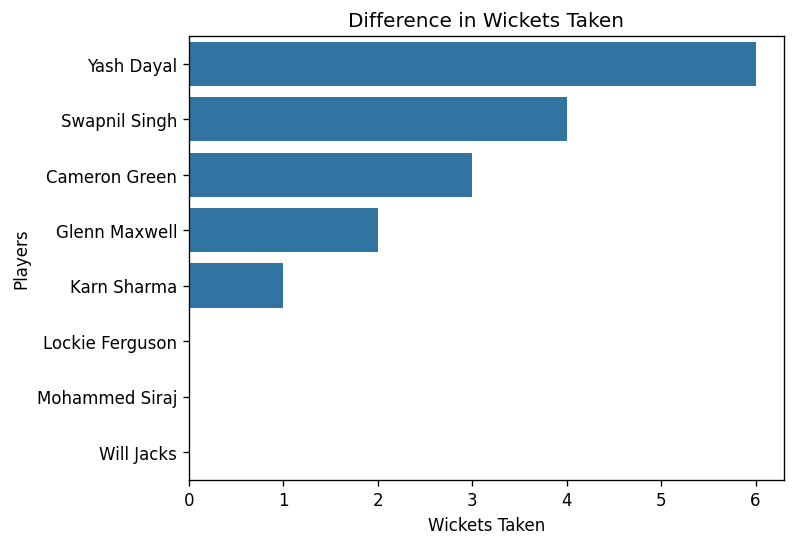

In [73]:
plt.figure(dpi = 120)
sns.barplot(x = bowling_diff["Wickets_Taken"], y = bowling_diff.index)
plt.title("Difference in Wickets Taken")
plt.ylabel("Players")
plt.xlabel("Wickets Taken")
plt.show()

Total Wickets Contribution

---



In [74]:
top_bowling = (done_bowling.groupby("Player_Name")["Wickets_Taken"].sum()).sort_values(ascending = False)
other_bowlers = bowling_diff["Wickets_Taken"].sum() - top_bowling.sum()
bowling_data = top_bowling.copy()
bowling_data["Others"] = other_bowlers
bowling_data = (bowling_data[bowling_data > 0])

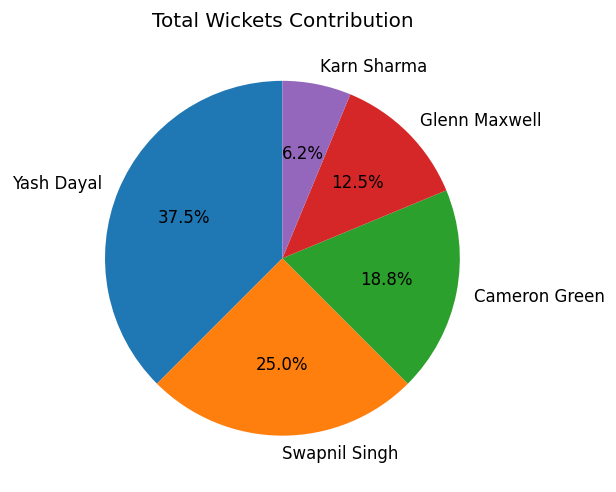

In [75]:
plt.figure(dpi = 120)
plt.pie(bowling_data, labels=bowling_data.index, autopct="%1.1f%%", startangle=90)
plt.title("Total Wickets Contribution")
plt.show()

Strike-Rate Comparison between Batsmen and All-Rounders

---



In [76]:
batters_allrounders = done_batting[(done_batting["Role"] == "batsman") | (done_batting["Role"] == "all-rounder")]
strike_rate_diff = ((batters_allrounders.groupby("Player_Name").agg({"Strike_Rate": "mean", "Runs_Scored": "sum", "Balls_Played":"sum"})).sort_values(by= "Strike_Rate", ascending = False)).round(2)
strike_rate_diff

,Strike_Rate,Runs_Scored,Balls_Played
Player_Name,,,
Mahipal Lomror,292.64,32.0,19.0
Anuj Rawat,275.00,11.0,4.0
Will Jacks,207.67,112.0,48.0
Dinesh Karthik,202.10,43.0,24.0
Rajat Patidar,169.56,73.0,41.0
Virat Kohli,161.78,239.0,150.0
Saurav Chauhan,150.00,9.0,6.0
Cameron Green,115.18,49.0,32.0
Faf du Plessis,85.72,12.0,14.0


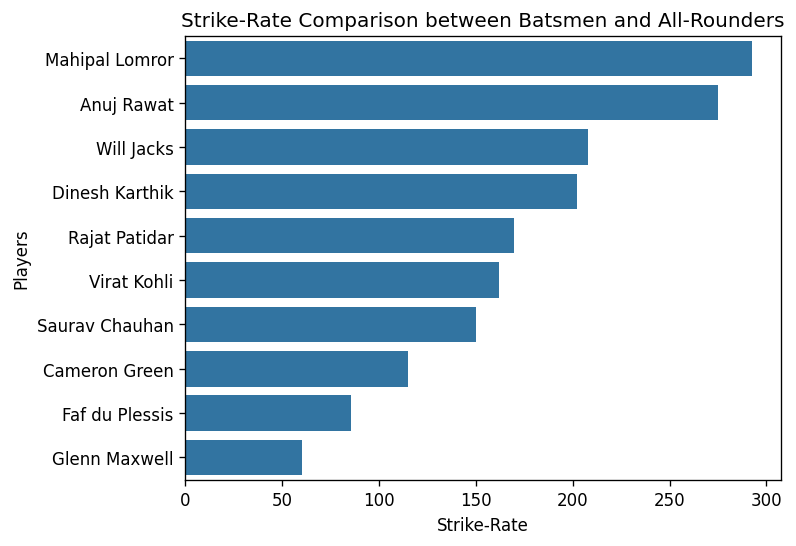

In [77]:
plt.figure(dpi = 120)
sns.barplot(x = strike_rate_diff["Strike_Rate"], y = strike_rate_diff.index)
plt.title("Strike-Rate Comparison between Batsmen and All-Rounders")
plt.xlabel("Strike-Rate")
plt.ylabel("Players")
plt.show()

Economy-Rate Comparison between Bowlers and All-Rounders


---



In [78]:
bowlers_allrounders = done_bowling[(done_bowling["Role"] == "bowler") |( done_bowling["Role"] == "all-rounder")]
economy_diff = ((bowlers_allrounders.groupby("Player_Name").agg({"Economy_Rate":"mean", "Overs_Bowled": "sum", "Runs_Given": "sum"})).sort_values(by = "Economy_Rate")).round(2)
economy_diff

,Economy_Rate,Overs_Bowled,Runs_Given
Player_Name,,,
Yash Dayal,5.58,12.0,67.0
Swapnil Singh,7.00,8.0,56.0
Karn Sharma,8.62,8.0,69.0
Glenn Maxwell,9.67,3.0,29.0
Cameron Green,10.11,9.0,93.0
Mohammed Siraj,11.17,12.0,134.0
Lockie Ferguson,13.00,1.0,13.0
Will Jacks,13.50,2.0,27.0


Text(0, 0.5, 'Players')

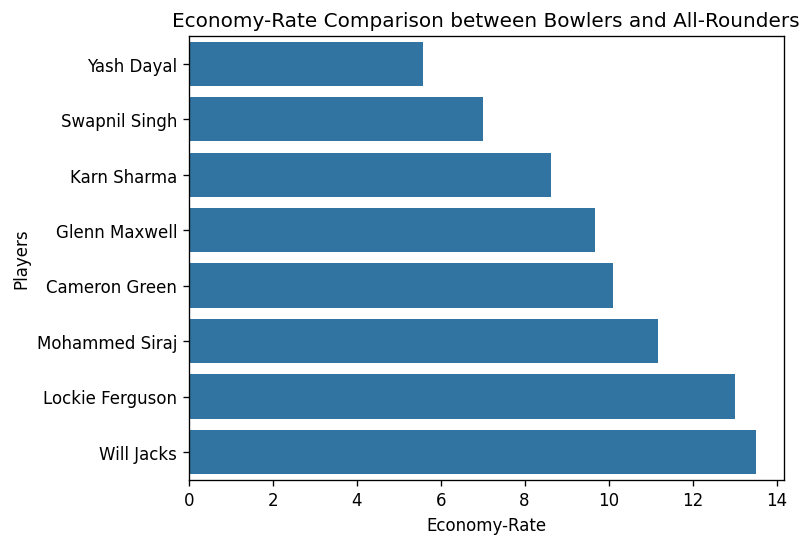

In [79]:
plt.figure(dpi = 120)
sns.barplot(x = economy_diff["Economy_Rate"], y = economy_diff.index)
plt.title("Economy-Rate Comparison between Bowlers and All-Rounders")
plt.xlabel("Economy-Rate")
plt.ylabel("Players")

Total Runs Scored Contribution Based on Roles

---




In [80]:
runs_contribution_by_role = done_batting[done_batting["Runs_Scored"] > 0]
runs_contribution_by_role = (runs_contribution_by_role.groupby("Role")["Runs_Scored"].sum()).sort_values(ascending = False)
runs_contribution_by_role

,Runs_Scored
Role,
batsman,419.0
all-rounder,164.0


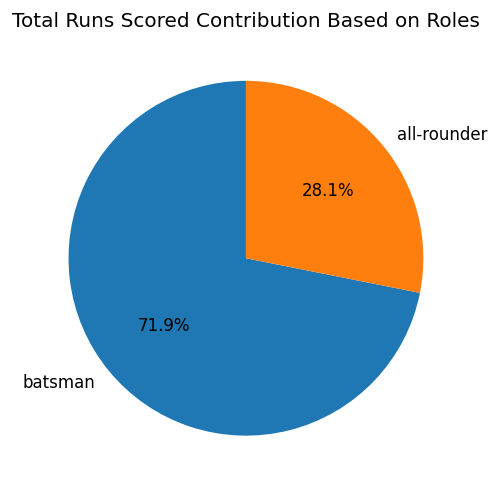

In [81]:
plt.figure(dpi = 120)
plt.pie(runs_contribution_by_role, labels=runs_contribution_by_role.index, autopct="%1.1f%%", startangle=90)
plt.title("Total Runs Scored Contribution Based on Roles")
plt.show()

Total Wickets Taken Contribution Based on Roles

---

In [82]:
wickets_contribution_by_role = done_bowling[done_bowling["Wickets_Taken"] > 0]
wickets_contribution_by_role = (wickets_contribution_by_role.groupby("Role")["Wickets_Taken"].sum()).sort_values(ascending = False)
wickets_contribution_by_role

,Wickets_Taken
Role,
all-rounder,9.0
bowler,7.0


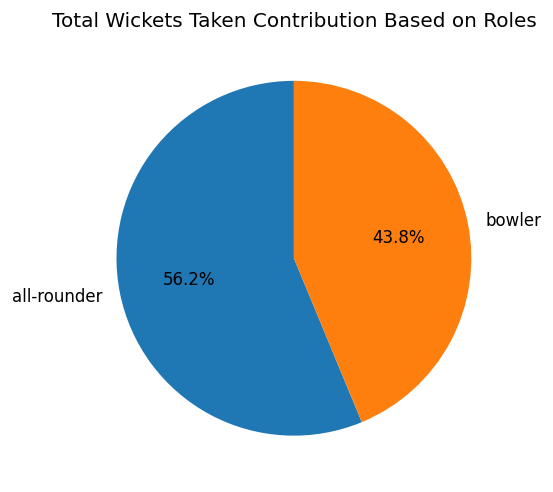

In [83]:
plt.figure(dpi = 120)
plt.pie(wickets_contribution_by_role, labels=wickets_contribution_by_role.index, autopct="%1.1f%%", startangle=90)
plt.title("Total Wickets Taken Contribution Based on Roles")
plt.show()

Players Consitencey in Batting

---



In [84]:
match_balls_played = df2[df2["Balls_Played"] > 0]
match_runs = match_balls_played.groupby(["Match_No", "Player_Name"])["Runs_Scored"].sum().reset_index()

In [85]:
if match_balls_played["Match_No"].nunique() > 1:
  batting_consistency = (match_runs.groupby("Player_Name")["Runs_Scored"].agg(["mean", "std","count"])).round(2)
  batting_consistency = batting_consistency[batting_consistency["count"] > 1]
  batting_consistency["Consistency_Score"] = (batting_consistency["mean"] / (batting_consistency["std"] + 1)).round(2)
  batting_consistency = batting_consistency.sort_values(by = "Consistency_Score", ascending = False)
else:
  print("Players Consistency in Batting is not applicable for single match dataset")
batting_consistency

,mean,std,count,Consistency_Score
Player_Name,,,,
Virat Kohli,79.67,11.24,3,6.51
Dinesh Karthik,21.50,4.95,2,3.61
Mahipal Lomror,16.00,9.90,2,1.47
Rajat Patidar,36.50,26.16,2,1.34
Faf du Plessis,6.00,4.24,2,1.15
Will Jacks,56.00,62.23,2,0.89
Cameron Green,24.50,30.41,2,0.78


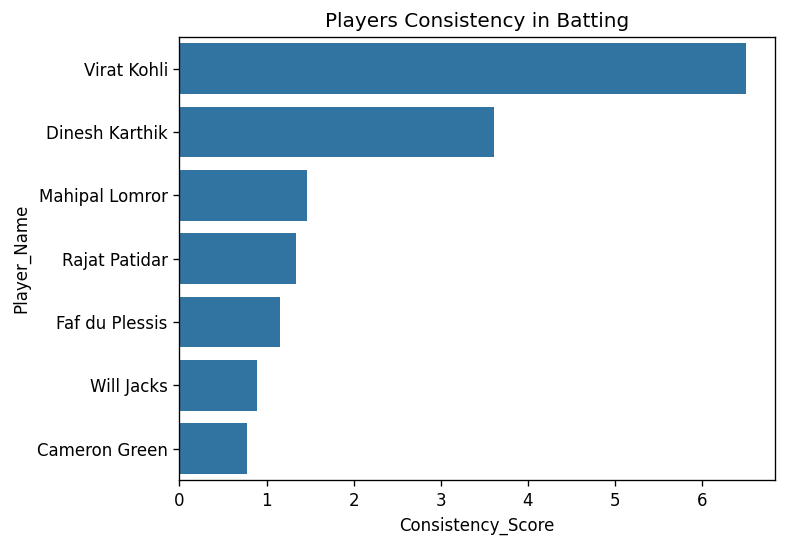

In [86]:
if match_balls_played["Match_No"].nunique() > 1:
  plt.figure(dpi = 120)
  sns.barplot(y = batting_consistency.index, x = batting_consistency["Consistency_Score"])
  plt.title("Players Consistency in Batting")
  plt.show()
else:
   print("Players Consistency in Batting is not applicable for single match dataset")

Players Consistency in Bowling

---



In [87]:
match_overs = df2[df2["Overs_Bowled"] > 0]
match_wickets = match_overs.groupby(["Match_No", "Player_Name"])["Wickets_Taken"].sum().reset_index()

In [88]:
if match_overs["Match_No"].nunique() > 1:
  bowling_consistency = (match_wickets.groupby("Player_Name")["Wickets_Taken"].agg(["mean", "std","count"])).round(2)
  bowling_consistency = bowling_consistency[bowling_consistency["count"] > 1]
  bowling_consistency["Consistency_Score"] = (bowling_consistency["mean"] / (bowling_consistency["std"] + 1)).round(2)
  bowling_consistency = bowling_consistency.sort_values(by = "Consistency_Score", ascending = False)
else :
  print("Players Consistency in Bowling in not applicable for single match dataset")
bowling_consistency

,mean,std,count,Consistency_Score
Player_Name,,,,
Yash Dayal,2.0,0.00,3,2.00
Swapnil Singh,2.0,0.00,2,2.00
Cameron Green,1.0,1.00,3,0.50
Karn Sharma,0.5,0.71,2,0.29
Mohammed Siraj,0.0,0.00,3,0.00


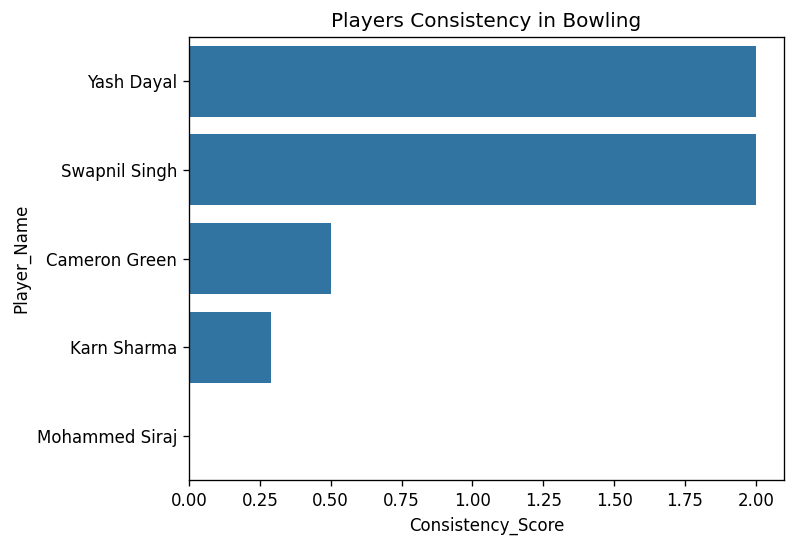

In [89]:
if match_overs["Match_No"].nunique() > 1:
  plt.figure(dpi = 120)
  sns.barplot(y = bowling_consistency.index, x = bowling_consistency["Consistency_Score"])
  plt.title("Players Consistency in Bowling")
  plt.show()
else:
  print("Players Consistency in Bowling is not applicable for single match dataset")


Average Runs by Batting Position

---



In [90]:
if ( (df2["Match_No"].nunique()) > 1 ):
  avg_runs_by_position = ((done_batting.groupby("Batting_Position")["Runs_Scored"].mean()).sort_index()).round(2)
else :
  print("Not applicable for single match dataset")
avg_runs_by_position

,Runs_Scored
Batting_Position,
1,79.67
2,37.33
3,7.50
4,36.50
5,24.50
6,21.50
7,16.00
8,9.00
9,11.00


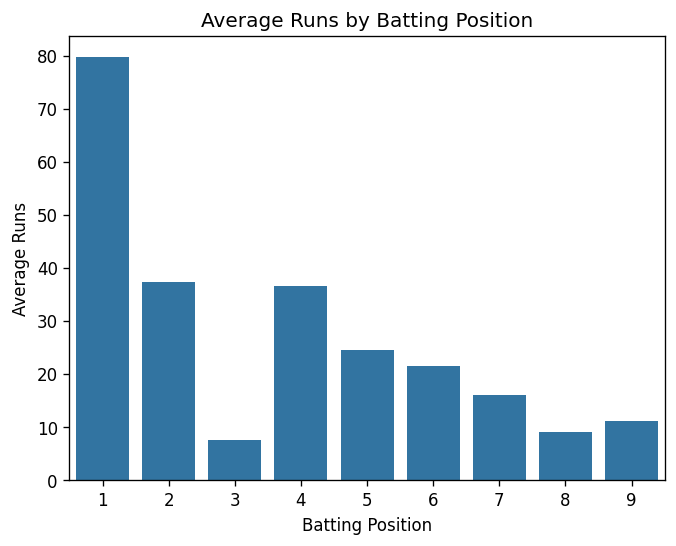

In [91]:
if ( (df2["Match_No"].nunique()) > 1 ):
  plt.figure(dpi=120)
  sns.barplot(x=avg_runs_by_position.index, y=avg_runs_by_position.values)
  plt.title("Average Runs by Batting Position")
  plt.xlabel("Batting Position")
  plt.ylabel("Average Runs")
  plt.show()
else :
  print("Average Runs by Batting is not applicable for single match dataset")

Phase wise Wickets breakdown

---



In [92]:
wickets_df = df2[df2["Was_Out"] == True].copy()
wickets_df["Out_Over"] = pd.to_numeric(wickets_df["Out_Over"], errors="coerce")
def assign_phase(over):
    if over <= 6:
        return "Powerplay"
    elif over <= 15:
        return "Middle Overs"
    else:
        return "Death Overs"

wickets_df["Wicket_Phase"] = wickets_df["Out_Over"].apply(assign_phase)

phase_wickets = (wickets_df.groupby("Wicket_Phase")["Player_Name"].size().reindex(["Powerplay", "Middle Overs", "Death Overs"])).reset_index(name="Wickets_Lost")
phase_wickets

,Wicket_Phase,Wickets_Lost
0,Powerplay,6
1,Middle Overs,2
2,Death Overs,8


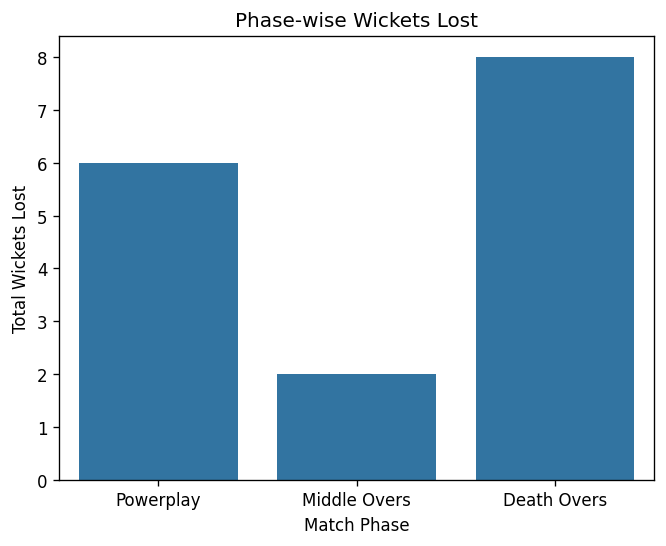

In [93]:
plt.figure(dpi = 120)
sns.barplot(x=phase_wickets["Wicket_Phase"],y=phase_wickets["Wickets_Lost"])
plt.title("Phase-wise Wickets Lost")
plt.xlabel("Match Phase")
plt.ylabel("Total Wickets Lost")
plt.show()

Team Total Runs in Each Match

---



In [94]:
if done_batting["Match_No"].nunique() > 1:
  runs_each_match = done_batting.groupby("Match_No")["Runs_Scored"].sum()
else :
  print("Team Total Runs in Each Match is not applicable for single match dataset.")
runs_each_match

,Runs_Scored
Match_No,
1,172.0
2,241.0
3,170.0


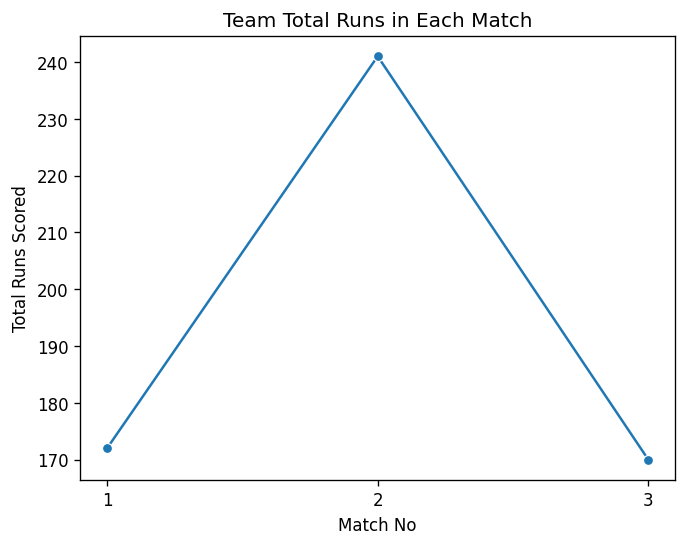

In [131]:
if done_batting["Match_No"].nunique() > 1:
  x_vals = runs_each_match.index.astype(int)
  y_vals = runs_each_match.values
  plt.figure(dpi = 120)
  sns.lineplot(x=x_vals, y=y_vals, marker="o")

  plt.xticks(range(min(x_vals), max(x_vals)+1))
  plt.title("Team Total Runs in Each Match")
  plt.xlabel("Match No")
  plt.ylabel("Total Runs Scored")
  plt.show()
else:
    print("Team Total Runs in Each Match is not applicable for single match dataset.")

Player's Total Runs in Each Match

---



In [124]:
if done_batting["Match_No"].nunique() > 1:
  players_list = done_batting["Player_Name"].unique().tolist()
  print("Enter the Player's Index to see the Total Runs Scored by that player in each match")
  for index, player in enumerate(players_list) :
    print(f"{index+1} : {player}")
  player_index = int(input("enter your choice : "))
  selected_player = players_list[player_index - 1]
  selected_player_df = done_batting[done_batting["Player_Name"] == selected_player]
  print(f"{selected_player}'s Total Runs in Each Match")
  player_runs = selected_player_df.groupby("Match_No")["Runs_Scored"].sum().reset_index()
  print()
else :
  print("Players Total Runs in Each Match is not applicable for single match dataset.")
player_runs

Enter the Player's Index to see the Total Runs Scored by that player in each match
1 : Virat Kohli
2 : Faf du Plessis
3 : Cameron Green
4 : Rajat Patidar
5 : Glenn Maxwell
6 : Dinesh Karthik
7 : Mahipal Lomror
8 : Saurav Chauhan
9 : Anuj Rawat
10 : Will Jacks
enter your choice : 1
Virat Kohli's Total Runs in Each Match



,Match_No,Runs_Scored
0,1,77.0
1,2,92.0
2,3,70.0


Enter the Player's Index to see the Total Runs Scored by that player in each match
1 : Virat Kohli
2 : Faf du Plessis
3 : Cameron Green
4 : Rajat Patidar
5 : Glenn Maxwell
6 : Dinesh Karthik
7 : Mahipal Lomror
8 : Saurav Chauhan
9 : Anuj Rawat
10 : Will Jacks
enter your choice : 1
Virat Kohli's Total Runs in Each Match



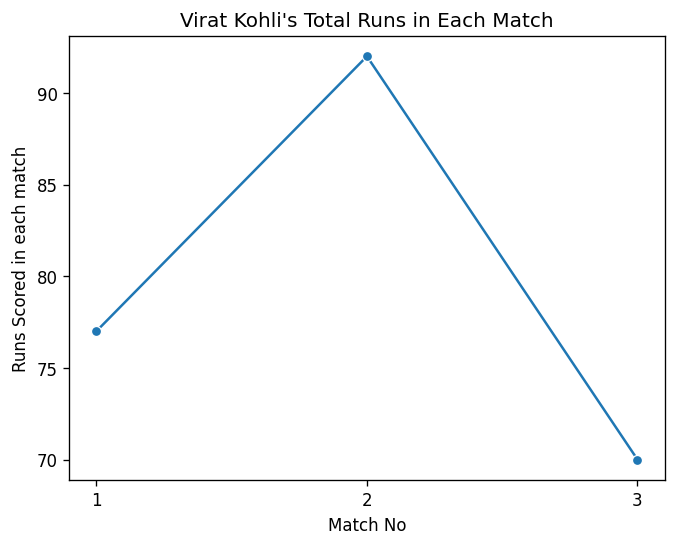

In [130]:
if done_batting["Match_No"].nunique() > 1:
  players_list = done_batting["Player_Name"].unique().tolist()
  print("Enter the Player's Index to see the Total Runs Scored by that player in each match")
  for index, player in enumerate(players_list) :
    print(f"{index+1} : {player}")
  player_index = int(input("enter your choice : "))
  selected_player = players_list[player_index - 1]
  selected_player_df = done_batting[done_batting["Player_Name"] == selected_player]
  print(f"{selected_player}'s Total Runs in Each Match")
  player_runs = selected_player_df.groupby("Match_No")["Runs_Scored"].sum().reset_index()
  print()

  x_vals = player_runs["Match_No"].astype(int)
  y_vals = player_runs["Runs_Scored"]
  plt.figure(dpi = 120)
  sns.lineplot(x=x_vals, y=y_vals, marker="o")

  plt.xticks(range(min(x_vals), max(x_vals)+1))
  plt.title(f"{selected_player}'s Total Runs in Each Match")
  plt.xlabel("Match No")
  plt.ylabel("Runs Scored in each match")
  plt.show()

Team Total Wickets in Each Match

---



In [123]:
if done_bowling["Match_No"].nunique() > 1:
  wickets_each_match = done_bowling.groupby("Match_No")["Wickets_Taken"].sum()
else :
  print("Team Total Wickets in Each Match is not applicable for single match dataset.")
wickets_each_match

,Wickets_Taken
Match_No,
1,4.0
2,6.0
3,6.0


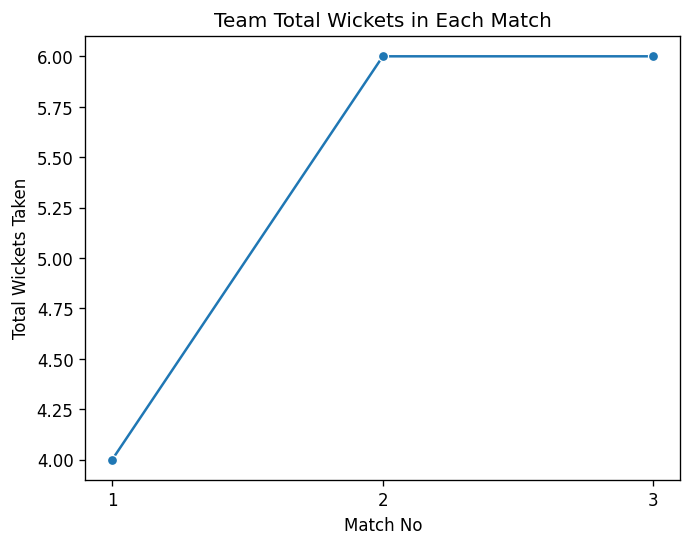

In [129]:
if done_bowling["Match_No"].nunique() > 1:
    wickets_each_match = (done_bowling.groupby("Match_No")["Wickets_Taken"].sum().sort_index())
    x_vals = wickets_each_match.index.astype(int)
    y_vals = wickets_each_match.values
    plt.figure(dpi=120)
    sns.lineplot(x=x_vals, y=y_vals, marker="o")
    plt.xticks(range(min(x_vals), max(x_vals) + 1))
    plt.title("Team Total Wickets in Each Match")
    plt.xlabel("Match No")
    plt.ylabel("Total Wickets Taken")
    plt.show()

else:
    print("Team Total Wickets in Each Match is not applicable for single match dataset.")


Player's Total Wickets in Each Match

---



In [122]:
if done_bowling["Match_No"].nunique() > 1:
  players_list_bowl = done_bowling["Player_Name"].unique().tolist()
  print("Enter the Player's Index to see the Total Wickets taken by that player in each match")
  for index, player in enumerate(players_list_bowl) :
    print(f"{index+1} : {player}")
  player_index_bowl = int(input("enter your choice : "))
  selected_player_bowl = players_list_bowl[player_index_bowl - 1]
  selected_player_bowl_df = done_bowling[done_bowling["Player_Name"] == selected_player_bowl]
  print(f"{selected_player_bowl}'s Total Wickets in Each Match")
  player_wickets = selected_player_bowl_df.groupby("Match_No")["Wickets_Taken"].sum().reset_index()
  print()
else :
  print("Player's Total Wickets in Each Match is not applicable for single match dataset.")
player_wickets

Enter the Player's Index to see the Total Wickets taken by that player in each match
1 : Cameron Green
2 : Glenn Maxwell
3 : Mohammed Siraj
4 : Yash Dayal
5 : Will Jacks
6 : Swapnil Singh
7 : Karn Sharma
8 : Lockie Ferguson
enter your choice : 4
Yash Dayal's Total Wickets in Each Match



,Match_No,Wickets_Taken
0,1,2.0
1,2,2.0
2,3,2.0


Enter the Player's Index to see the Total Wickets taken by that player in each match
1 : Cameron Green
2 : Glenn Maxwell
3 : Mohammed Siraj
4 : Yash Dayal
5 : Will Jacks
6 : Swapnil Singh
7 : Karn Sharma
8 : Lockie Ferguson
enter your choice : 8
Lockie Ferguson's Total Wickets in Each Match



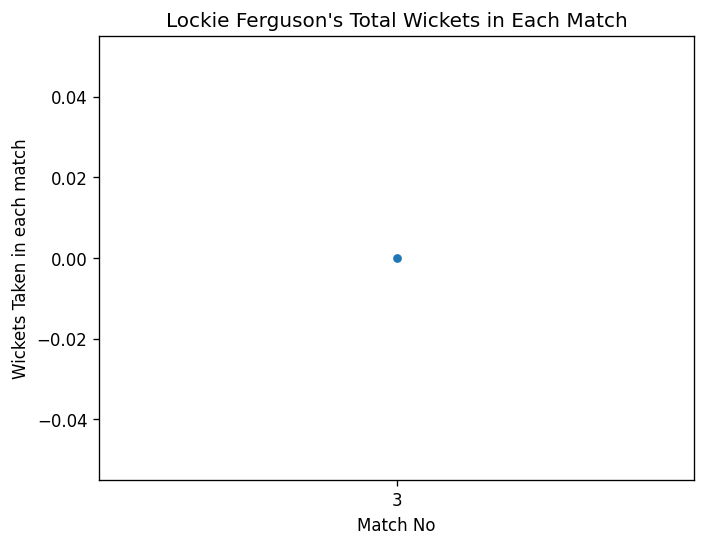

In [128]:
if done_bowling["Match_No"].nunique() > 1:
    players_list_bowl = done_bowling["Player_Name"].unique().tolist()
    print("Enter the Player's Index to see the Total Wickets taken by that player in each match")

    for index, player in enumerate(players_list_bowl):
        print(f"{index+1} : {player}")
    player_index_bowl = int(input("enter your choice : "))
    selected_player_bowl = players_list_bowl[player_index_bowl - 1]
    selected_player_bowl_df = done_bowling[done_bowling["Player_Name"] == selected_player_bowl]
    print(f"{selected_player_bowl}'s Total Wickets in Each Match")
    print()
    player_wickets = (selected_player_bowl_df.groupby("Match_No")["Wickets_Taken"].sum().reset_index().sort_values("Match_No"))

    x_vals = player_wickets["Match_No"].astype(int)
    y_vals = player_wickets["Wickets_Taken"]

    plt.figure(dpi=120)
    sns.lineplot(x=x_vals, y=y_vals, marker="o")

    plt.xticks(range(min(x_vals), max(x_vals) + 1))
    plt.title(f"{selected_player_bowl}'s Total Wickets in Each Match")
    plt.xlabel("Match No")
    plt.ylabel("Wickets Taken in each match")
    plt.show()

else:
    print("Player's Total Wickets in Each Match is not applicable for single match dataset.")
